In [1]:
import torch
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
training_dataset = MNIST(root='data/', download=True, transform=ToTensor())
training_dataset

100%|██████████| 9.91M/9.91M [00:00<00:00, 57.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.65MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.6MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.08MB/s]


Dataset MNIST
    Number of datapoints: 60000
    Root location: data/
    Split: Train
    StandardTransform
Transform: ToTensor()

In [3]:
validating_dataset = MNIST(root='data/', train=False, transform=ToTensor())
validating_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: data/
    Split: Test
    StandardTransform
Transform: ToTensor()

In [5]:
# training_dataset[0]

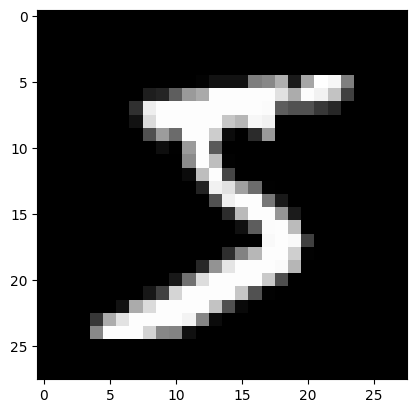

In [6]:
image, label = training_dataset[0]
plt.imshow(image[0,:,:], cmap="gray")

In [7]:
batch_size = 100

training_dataloader = DataLoader(training_dataset, batch_size, shuffle=True)

validating_dataloader = DataLoader(validating_dataset, batch_size, shuffle=True)

len(training_dataloader), len(validating_dataloader)

(600, 100)

In [8]:
def show_batch_images(dataloader):
  for images, labels in dataloader:
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images[:100], 10).permute(1,2,0))
    break;

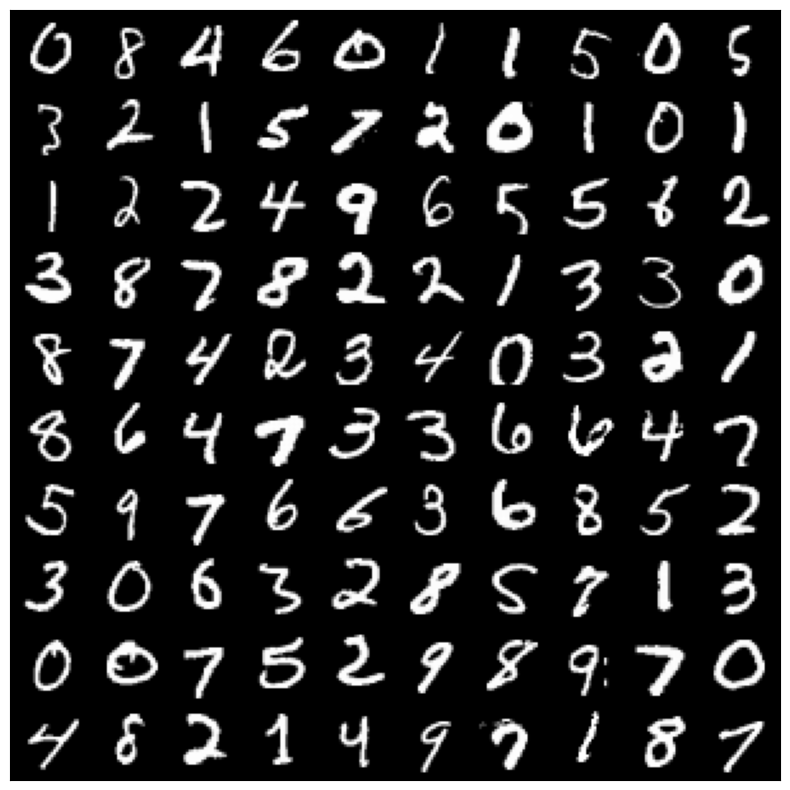

In [9]:
show_batch_images(training_dataloader)

In [10]:
class ImageClassifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
    self.pool = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
    self.fc1 = nn.Linear(64 * 14 * 14, 128)
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, 10)

  def forward(self, input):
    x = self.conv1(input)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = self.pool(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    x = F.relu(x)
    x = self.fc3(x)
    return x

In [11]:
model = ImageClassifier()
model

ImageClassifier(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=12544, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [12]:
# load pre-trained model
# model.load_state_dict(torch.load('image-cnn.pth'))
# model.state_dict()

In [13]:
learning_rate  = 0.001
epochs = 10

loss_function = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [14]:
def accuracy(outputs, labels):
  _, predictions = torch.max(outputs, dim=1)

  return torch.sum(predictions == labels).item() / len(predictions)


In [15]:
def fit(epochs, model, loss_function, learning_rate, training_dl, optimizer=None):

  if optimizer is None:
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
  else: # Adam
    optimizer = optim(model.parameters(), lr=learning_rate)

  for epoch in range(epochs):
    model.train()
    total_loss = 0
    batch_no = 0
    for input, target in training_dl:
      batch_no += 1
      optimizer.zero_grad()
      logit = model(input)
      loss = loss_function(logit, target)
      loss.backward()
      optimizer.step()
      total_loss += loss.item()

      if batch_no % 50 == 0:
        print(f"Loss: {loss.item():.4f}")



    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss:.4f}")
  print("Training finished")

In [ ]:
fit(epochs, model, loss_function, learning_rate, training_dataloader)

Loss: 0.0924
Loss: 0.0858
Loss: 0.0953
Loss: 0.1112
Loss: 0.0396
Loss: 0.1912
Loss: 0.0799
Loss: 0.0248
Loss: 0.1781
Loss: 0.0963
Loss: 0.0611
Loss: 0.0648
Epoch [1/10], Loss: 46.9935
Loss: 0.0322


KeyboardInterrupt: 

In [16]:
def predict_image(image, model):
  # Add a dimenion in the front [1,28,28] => [1,1,28,28]
  # This is done because the model is designed to accept inputs in batches
  # and even when processing a single image, it expects a batch dimension
  xb = image.unsqueeze(0)
  # Move the image to the same device as the model
  # xb = to_device(xb, next(model.parameters()).device)
  model.eval()
  with torch.no_grad():
    yb = model(xb)
    print("yb ", yb)
    # Index of the maximum value
  _, prediction = torch.max(yb, dim=1)
  print("Prediction ", prediction)
  return prediction[0].item()

yb  tensor([[-0.0475, -0.1120,  0.0549,  0.0429, -0.0535, -0.1235,  0.1174, -0.0465,
          0.1174,  0.0965]])
Prediction  tensor([8])
Label: 5 - five Prediction: 8 - eight


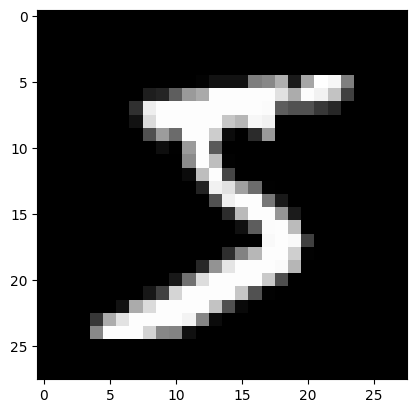

In [ ]:
image, label = training_dataset[0]

plt.imshow(image[-1,:,:], cmap='gray')
print("Label:", training_dataset.classes[label], "Prediction:", training_dataset.classes[predict_image(image, model)])

In [ ]:
def loss_batch(model, input_batch, target_batch, loss_function, optimizer=None, metric=None):

  predictions = model(input_batch)
  loss = loss_function(predictions, target_batch)

  # Metrics for validation set
  metric_result = None
  if metric is not None:
    metric_result = metric(predictions, target_batch)

  return loss.item(), len(input_batch), metric_result

In [ ]:
def evaluate(model, loss_function, validation_dl, metric=None):
  model.eval()
  with torch.no_grad():
    # Pass each batch through the model
    results = [loss_batch(model, input_batch, target_batch, loss_function, metric=metric)
    for input_batch, target_batch in validation_dl]
  losses, counts, accuracies = zip(*results)

  total = np.sum(counts)

  # Average loss and accuracy
  average_loss = np.sum(np.multiply(losses, counts)) / total
  average_accuracy = None
  if metric is not None:
    average_accuracy = np.sum(np.multiply(accuracies, counts)) / total

  return average_loss, total, average_accuracy


In [ ]:
average_loss, total, average_accuracy = evaluate(model, loss_function, validating_dataloader, metric=accuracy)
print("Average loss:", average_loss)
print("Total:", total)
print("Average accuracy:", average_accuracy)

Average loss: 0.07684580771252512
Total: 10000
Average accuracy: 0.9768


In [ ]:
# torch.save(model.state_dict(), 'image-cnn.pth')

In [ ]:
# from google.colab import files
# files.download("image-cnn.pth")

In [ ]:
# !pip install --upgrade gradio

In [18]:
import gradio as gr

In [20]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),   # RGB → grayscale
    transforms.Resize((28, 28)),                   # Ensure correct size
    transforms.ToTensor(),                         # PIL → tensor, scales to [0,1]
    transforms.Normalize((0.1307,), (0.3081,))     # Optional: same as MNIST training
])


def convertimage(input: str):
    img_array = input["composite"]
    # plt.imshow(img_array, cmap="gray")
    img = Image.fromarray(img_array[..., :3]).convert("L")
    tensor = transform(img)
    plt.imshow(tensor[0,:,:], cmap="gray")
    return tensor.unsqueeze(0)


def classify_image(img):
    tensor = convertimage(img)
    model.eval()
    with torch.no_grad():
        output = model(tensor)
        print(output)
        print(torch.max(output, dim=1))
    return torch.argmax(output).item()

gr.Interface(fn=classify_image, inputs="sketchpad", outputs="label").launch(share=True, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://6c4aea9d9405a57ff9.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7861 <> https://6c4aea9d9405a57ff9.gradio.live


In [ ]:
# !gradio deploy

In [ ]:
# Export model to onnx
# !pip install onnxruntime onnxruntime-tools
torch.onnx.export(model, torch.randn(1, 1, 28, 28), "onnx-image-cnn.onnx")

In [ ]:
# !pip install onnx onnx-tf tensorflow

In [25]:
# We quantize the model i.e. downsize the model from high precision floating point numbers
# in parameters to 8-bit integer
# !python -m onnxruntime.quantization.preprocess --input onnx-image-cnn.onnx --output infer-onnx-image-cnn.onnx

In [26]:
# !pip install --upgrade tensorflow==2.13

In [27]:
# !onnx-tf convert -i infer-onnx-image-cnn.onnx -o tfjs-image-cnn

In [28]:
# !pip install onnxruntime onnxruntime-tools

# !python -m onnxruntime.tools.quantization.quantize_dynamic \
#   --model_input infer-onnx-image-cnn.onnx \
#   --model_output latest-infer-onnx-quant.onnx \
#   --weight_type QInt8